# OpenAQ → AQI Estimator (Regression) — Full Notebook (EDA + Feature Engineering + Training + Export)

**Goal:** build an **AQI estimator** (supervised regression) that predicts **AQI at time _t_** from pollutant readings at the same timestamp (plus time + location features), robust to missing pollutant values.

> This is **not** time-series forecasting. We do **not** try to predict AQI at _t+1_ from past values only.

## 0) Setup
- Uses your project modules: `src.preprocessing`, `src.aqi`, `src.features`, `src.evaluate`
- Keeps the same artifact names at the end:
  - `models/aqi_estimator.joblib`
  - `models/feature_cols.json`
  - `models/model_meta.json`

In [1]:
# === Clone repo (Colab) ===
!git clone https://github.com/AshVenn/openaq-aqi-predictor.git
%cd openaq-aqi-predictor

Cloning into 'openaq-aqi-predictor'...
remote: Enumerating objects: 19297, done.
remote: Counting objects: 100% (1151/1151), done.
remote: Compressing objects: 100% (1007/1007), done.
remote: Total 19297 (delta 136), reused 1115 (delta 106), pack-reused 18146 (from 1)
Receiving objects: 100% (19297/19297), 165.92 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (1839/1839), done.
/content/openaq-aqi-predictor


In [2]:
# === Install deps (Colab) ===
!pip -q install xgboost catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [3]:
# === Setup ===
from pathlib import Path
import json
import sys
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
import joblib

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore")

ROOT = Path.cwd()
sys.path.insert(0, str(ROOT))

from src import preprocessing
from src.aqi import compute_aqi_dataframe
from src.evaluate import regression_metrics
from src.features import add_time_features

POLLUTANTS_ALL = ["pm25", "pm10", "no2", "o3", "co", "so2"]
INPUT_POLLUTANTS = POLLUTANTS_ALL.copy()

SIMULATE_MISSINGNESS = True
MISSING_PROB = 0.2
MIN_NON_MISSING_PER_COL = 50
RANDOM_SEED = 42

TRAIN_FREQ = "D"   # daily by default (more stable than hourly for sparse OpenAQ)
TEST_SIZE = 0.2

raw_path = ROOT / "data" / "openaq.csv"
print("Raw path:", raw_path)

Raw path: /content/openaq-aqi-predictor/data/openaq.csv


## 1) Load + Clean (Long Format)

In [4]:
raw_df = preprocessing.load_raw_data(str(raw_path))
clean_df = preprocessing.clean_raw_data(raw_df)

print(f"Raw rows: {len(raw_df):,}")
print(f"Clean rows: {len(clean_df):,}")
display(clean_df.head())

Pollutant counts after cleaning:
pollutant
no2     11126
pm25    10652
o3       9375
pm10     9261
so2      8059
co       5966
Name: count, dtype: int64
Raw rows: 61,177
Clean rows: 54,439


,city,location,latitude,longitude,timestamp,pollutant,value_std,unit_std,source_name
0,NaN,市八十六中,23.1047,113.4332,2021-08-09 11:00:00,o3,0.018337,ppm,ChinaAQIData
1,NaN,市农科院,21.9508,108.6553,2020-12-31 16:00:00,so2,2.671297,ppb,ChinaAQIData
2,NaN,市发改委,29.8454,114.3107,2021-08-09 11:00:00,pm25,26.000000,ug/m3,ChinaAQIData
3,NaN,市委,30.4576,106.6303,2021-08-09 11:00:00,o3,0.046353,ppm,ChinaAQIData
4,NaN,市委党校,27.7314,112.0194,2021-08-09 11:00:00,no2,10.096718,ppb,ChinaAQIData


## 2) Quick EDA (Long Format)

In [5]:
print("Columns:", list(clean_df.columns))
print("\nNull counts:")
display(clean_df.isna().sum().sort_values(ascending=False))

print("\nPollutant counts:")
display(clean_df["pollutant"].value_counts())

clean_df["timestamp"] = pd.to_datetime(clean_df["timestamp"], errors="coerce")
print("\nTime range:", clean_df["timestamp"].min(), "->", clean_df["timestamp"].max())

if "location" in clean_df.columns:
    print("Unique locations:", clean_df["location"].nunique())

if {"latitude","longitude"}.issubset(clean_df.columns):
    lat = clean_df["latitude"]
    lon = clean_df["longitude"]
    print("\nLatitude range:", (lat.min(), lat.max()))
    print("Longitude range:", (lon.min(), lon.max()))
    print("Lat missing:", int(lat.isna().sum()), "Lon missing:", int(lon.isna().sum()))

    # Negative values are NORMAL (west/south hemispheres). Check ranges instead.
    out_lat = clean_df[(lat < -90) | (lat > 90)]
    out_lon = clean_df[(lon < -180) | (lon > 180)]
    print("\nOut-of-range lat rows:", len(out_lat))
    print("Out-of-range lon rows:", len(out_lon))

Columns: ['city', 'location', 'latitude', 'longitude', 'timestamp', 'pollutant', 'value_std', 'unit_std', 'source_name']

Null counts:


,0
city,25679
latitude,70
longitude,70
location,2
timestamp,0
pollutant,0
value_std,0
unit_std,0
source_name,0



Pollutant counts:


,count
pollutant,
no2,11126
pm25,10652
o3,9375
pm10,9261
so2,8059
co,5966



Time range: 2014-03-13 12:00:00 -> 2025-01-31 23:00:00
Unique locations: 13940

Latitude range: (-74.16627777777778, 78.90668999996791)
Longitude range: (-161.767, 174.78)
Lat missing: 70 Lon missing: 70

Out-of-range lat rows: 0
Out-of-range lon rows: 0


### 2.1) EDA Plots (Long Format)

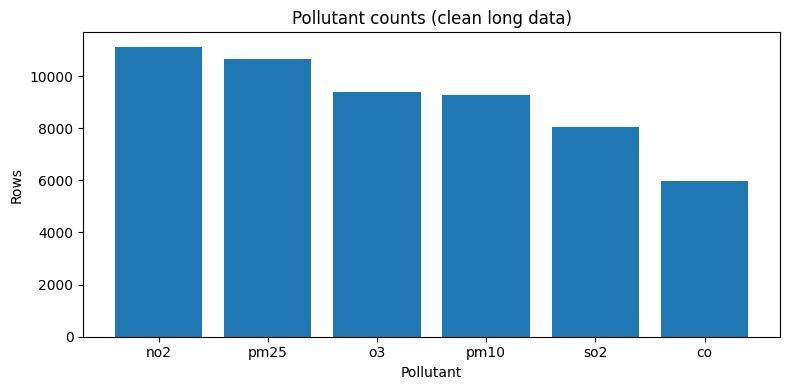

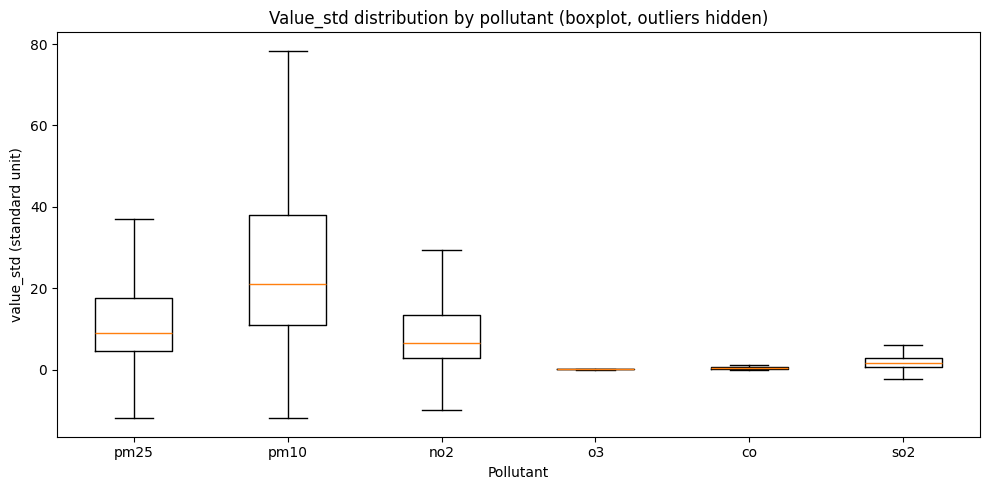

In [6]:
counts = clean_df["pollutant"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Pollutant counts (clean long data)")
plt.xlabel("Pollutant")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

if "value_std" in clean_df.columns:
    df_plot = clean_df[clean_df["value_std"].notna()].copy()
    plt.figure(figsize=(10,5))
    data = [df_plot[df_plot["pollutant"]==p]["value_std"].values for p in POLLUTANTS_ALL if p in df_plot["pollutant"].unique()]
    labels = [p for p in POLLUTANTS_ALL if p in df_plot["pollutant"].unique()]
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title("Value_std distribution by pollutant (boxplot, outliers hidden)")
    plt.xlabel("Pollutant")
    plt.ylabel("value_std (standard unit)")
    plt.tight_layout()
    plt.show()

### 2.2) Coverage Diagnostics

In [7]:
if {"location","timestamp"}.issubset(clean_df.columns):
    tmp = clean_df.dropna(subset=["location","timestamp"]).copy()
    tmp["day"] = tmp["timestamp"].dt.floor("D")
    day_cov = tmp.groupby("location")["day"].nunique().sort_values(ascending=False).head(10)
    print("Top 10 locations by distinct DAYS observed:")
    display(day_cov)

    tmp["hour_bin"] = tmp["timestamp"].dt.floor("H")
    hour_cov = tmp.groupby("location")["hour_bin"].nunique().sort_values(ascending=False).head(10)
    print("Top 10 locations by distinct HOURS observed:")
    display(hour_cov)

Top 10 locations by distinct DAYS observed:


,day
location,
MMCA81033,19
Centro,18
MMCA81010,18
GBUAPCD EBAM @ June,16
MMCA81014,14
MMFRA1001,14
GBUAPCD EBAM @ Bridg,13
Santa Fe,13
Vermillion,12


Top 10 locations by distinct HOURS observed:


,hour_bin
location,
North Charleston F.S,42
Richmond City Near R,35
TRPA Office,35
Escalante,32
Blair,30
White Springs Plant,30
Popham Beach SP,26
LYNN,25
MMCA81033,22


## 3) Aggregate + Pivot (Wide Format)

In [8]:
wide_df = preprocessing.aggregate_and_pivot(clean_df, freq=TRAIN_FREQ)
print("wide_df shape:", wide_df.shape)
display(wide_df.head())

processed_wide_path = ROOT / "data" / "processed_wide.csv"
wide_df.to_csv(processed_wide_path, index=False)
print("Saved:", processed_wide_path)

wide_df shape: (18968, 12)


,source_name,location,latitude,longitude,timestamp,co,no2,o3,pm10,pm25,so2,city
0,ARPALAZIO,Acquapendente,42.736649,11.876578,2025-01-10,NaN,NaN,NaN,14.0,8.0,NaN,Viterbo
1,ARPALAZIO,Acquapendente,42.736649,11.876578,2025-01-11,NaN,0.531406,0.02445,NaN,NaN,NaN,Viterbo
2,ARPALAZIO,Alatri,41.730000,13.338333,2025-01-10,NaN,NaN,NaN,41.0,NaN,NaN,Frosinone
3,ARPALAZIO,Alatri,41.730000,13.338333,2025-01-11,NaN,13.816562,NaN,NaN,NaN,NaN,Frosinone
4,ARPALAZIO,Alatri,41.730000,13.338333,2023-01-09,0.785612,NaN,NaN,NaN,NaN,NaN,Frosinone


Saved: /content/openaq-aqi-predictor/data/processed_wide.csv


## 4) Compute AQI Label (Deterministic)

In [9]:
aqi_df = compute_aqi_dataframe(wide_df)
print("aqi_df shape:", aqi_df.shape)
display(aqi_df[["timestamp","aqi"]].head(10))

processed_aqi_path = ROOT / "data" / "processed_aqi.csv"
aqi_df.to_csv(processed_aqi_path, index=False)
print("Saved:", processed_aqi_path)

aqi_df shape: (18968, 14)


,timestamp,aqi
0,2025-01-10,33.333333
1,2025-01-11,22.638889
2,2025-01-10,37.962963
3,2025-01-11,13.034492
4,2023-01-09,8.927412
5,2025-01-10,18.518519
6,2025-01-11,31.600116
7,2025-01-10,41.666667
8,2025-01-11,28.298611
9,2022-10-01,11.111111


Saved: /content/openaq-aqi-predictor/data/processed_aqi.csv


## 5) Feature Engineering

In [10]:
def ensure_pollutant_columns(df, pollutant_cols):
    df = df.copy()
    for p in pollutant_cols:
        if p not in df.columns:
            df[p] = np.nan
    return df

def add_missingness_indicators(df, pollutant_cols):
    df = df.copy()
    for p in pollutant_cols:
        df[f"{p}_is_missing"] = df[p].isna().astype(int)
    return df

features_df = ensure_pollutant_columns(aqi_df, POLLUTANTS_ALL)
features_df = add_time_features(features_df, time_col="timestamp")

features_df = features_df[features_df["aqi"].notna()].copy()

available_pollutants = [
    p for p in POLLUTANTS_ALL
    if p in features_df.columns and features_df[p].notna().sum() > 0
]

print("Non-null counts per pollutant:")
for p in POLLUTANTS_ALL:
    count = features_df[p].notna().sum() if p in features_df.columns else 0
    print(f"{p}: {count}")

INPUT_POLLUTANTS = available_pollutants
print(f"Using INPUT_POLLUTANTS: {INPUT_POLLUTANTS}")

base_geo = [c for c in ["latitude","longitude"] if c in features_df.columns]
feature_cols = (
    base_geo
    + ["hour", "day_of_week", "month"]
    + INPUT_POLLUTANTS
    + [f"{p}_is_missing" for p in INPUT_POLLUTANTS]
)

assert "aqi" not in feature_cols
print("Feature columns:")
print(feature_cols)

Non-null counts per pollutant:
pm25: 10182
pm10: 8933
no2: 10901
o3: 9146
co: 5874
so2: 7795
Using INPUT_POLLUTANTS: ['pm25', 'pm10', 'no2', 'o3', 'co', 'so2']
Feature columns:
['latitude', 'longitude', 'hour', 'day_of_week', 'month', 'pm25', 'pm10', 'no2', 'o3', 'co', 'so2', 'pm25_is_missing', 'pm10_is_missing', 'no2_is_missing', 'o3_is_missing', 'co_is_missing', 'so2_is_missing']


## 6) Optional: Simulate Missingness

In [11]:
from sklearn.model_selection import TimeSeriesSplit

def simulate_missingness(df, pollutant_cols, missing_prob=0.2, min_non_missing_per_col=50, seed=42):
    df = df.copy()
    rng = np.random.RandomState(seed)
    original = df[pollutant_cols].copy()

    mask = rng.rand(*original.shape) < missing_prob
    mask = mask & original.notna().values
    df[pollutant_cols] = original.mask(mask)

    all_missing = df[pollutant_cols].isna().all(axis=1)
    for idx in df.index[all_missing]:
        available = original.loc[idx].dropna()
        if not available.empty:
            restore_col = rng.choice(available.index)
            df.at[idx, restore_col] = original.at[idx, restore_col]

    for p in pollutant_cols:
        current_non_missing = df[p].notna().sum()
        if current_non_missing >= min_non_missing_per_col:
            continue
        candidates = original[p][original[p].notna()].index
        if len(candidates) == 0:
            continue
        needed = min_non_missing_per_col - current_non_missing
        restore_rows = rng.choice(candidates, size=min(needed, len(candidates)), replace=False)
        df.loc[restore_rows, p] = original.loc[restore_rows, p]

    return df

def enforce_non_missing_per_fold(df, original, pollutant_cols, n_splits=3, seed=42):
    df = df.copy()
    rng = np.random.RandomState(seed)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    indices = np.arange(len(df))

    for train_idx, _ in tscv.split(indices):
        for p in pollutant_cols:
            if df.iloc[train_idx][p].notna().sum() == 0:
                candidates = train_idx[original.iloc[train_idx][p].notna().values]
                if len(candidates) == 0:
                    continue
                restore_pos = rng.choice(candidates, size=1, replace=False)
                df.iloc[restore_pos, df.columns.get_loc(p)] = original.iloc[restore_pos][p].values

    return df

original_pollutants = features_df[INPUT_POLLUTANTS].copy()

if SIMULATE_MISSINGNESS and INPUT_POLLUTANTS:
    features_df = simulate_missingness(
        features_df,
        INPUT_POLLUTANTS,
        missing_prob=MISSING_PROB,
        min_non_missing_per_col=MIN_NON_MISSING_PER_COL,
        seed=RANDOM_SEED,
    )
    features_df = enforce_non_missing_per_fold(
        features_df,
        original_pollutants,
        INPUT_POLLUTANTS,
        n_splits=3,
        seed=RANDOM_SEED,
    )

features_df = add_missingness_indicators(features_df, INPUT_POLLUTANTS)

for p in INPUT_POLLUTANTS:
    assert features_df[p].notna().sum() > 0, f"{p} is fully missing"

print("OK: Missingness simulation + indicators ready.")

OK: Missingness simulation + indicators ready.


## 7) EDA on Features (AQI distribution + correlations)

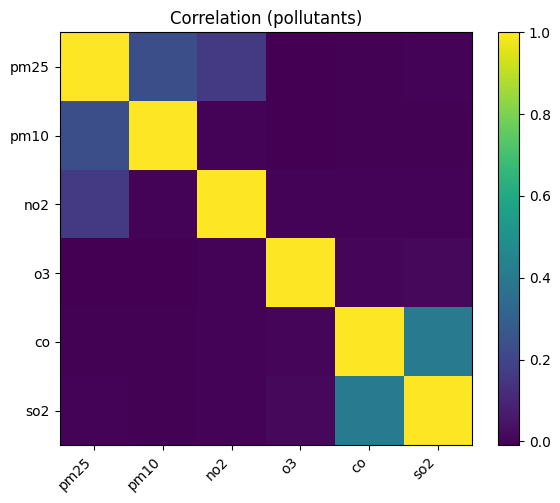

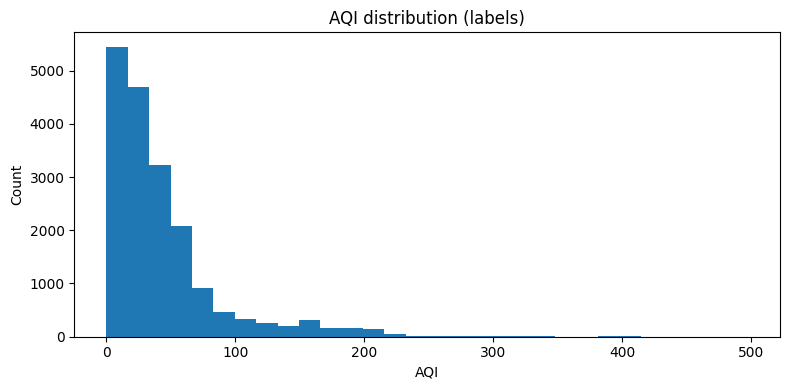

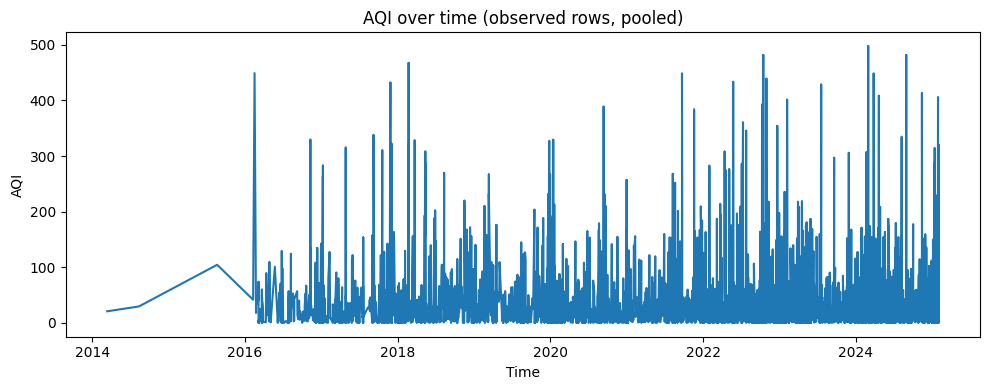

In [12]:
poll_cols = [p for p in INPUT_POLLUTANTS if p in features_df.columns]
if poll_cols:
    corr = features_df[poll_cols].corr()
    plt.figure(figsize=(6,5))
    plt.imshow(corr.values)
    plt.title("Correlation (pollutants)")
    plt.xticks(range(len(poll_cols)), poll_cols, rotation=45, ha="right")
    plt.yticks(range(len(poll_cols)), poll_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8,4))
plt.hist(features_df["aqi"].dropna().values, bins=30)
plt.title("AQI distribution (labels)")
plt.xlabel("AQI")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

tmp = features_df.sort_values("timestamp")
plt.figure(figsize=(10,4))
plt.plot(tmp["timestamp"].values, tmp["aqi"].values)
plt.title("AQI over time (observed rows, pooled)")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()

## 8) Train/Test Split + Training + Tuning

In [13]:
def time_split(df, time_col="timestamp", test_size=0.2):
    df = df.sort_values(time_col)
    split_idx = int(len(df) * (1 - test_size))
    return df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

def build_pipeline(estimator):
    return Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("model", estimator),
        ]
    )

train_df, test_df = time_split(features_df, time_col="timestamp", test_size=TEST_SIZE)

X_train = train_df[feature_cols]
y_train = train_df["aqi"]
X_test = test_df[feature_cols]
y_test = test_df["aqi"]

print("Train rows:", len(train_df), "Test rows:", len(test_df))
print("\nNon-missing counts in TRAIN split (pollutants):")
display(X_train[INPUT_POLLUTANTS].notna().sum())

Train rows: 14874 Test rows: 3719

Non-missing counts in TRAIN split (pollutants):


,0
pm25,6871
pm10,5349
no2,6773
o3,5902
co,4174
so2,5308


In [14]:
model_specs = {
    "LinearRegression": {"estimator": LinearRegression(), "param_grid": None},
    "Ridge": {"estimator": Ridge(random_state=RANDOM_SEED), "param_grid": {"model__alpha": [0.1, 1.0, 10.0, 100.0]}},
    "Lasso": {"estimator": Lasso(random_state=RANDOM_SEED, max_iter=5000), "param_grid": {"model__alpha": [0.001, 0.01, 0.1, 1.0]}},
    "RandomForest": {
        "estimator": RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1),
        "param_grid": {
            "model__n_estimators": [200, 400],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5],
            "model__min_samples_leaf": [1, 2],
        },
    },
    "XGBoost": {
        "estimator": XGBRegressor(objective="reg:squarederror", random_state=RANDOM_SEED, n_jobs=-1),
        "param_grid": {
            "model__n_estimators": [300, 600],
            "model__max_depth": [4, 6, 8],
            "model__learning_rate": [0.05, 0.1],
            "model__subsample": [0.8, 1.0],
            "model__colsample_bytree": [0.8, 1.0],
        },
    },
    "CatBoost": {
        "estimator": CatBoostRegressor(loss_function="RMSE", random_seed=RANDOM_SEED, verbose=False),
        "param_grid": {
            "model__depth": [6, 8, 10],
            "model__learning_rate": [0.03, 0.1],
            "model__iterations": [500, 1000],
        },
    },
}

results = []
best_models = {}
cv = TimeSeriesSplit(n_splits=3)

for name, spec in model_specs.items():
    pipeline = build_pipeline(spec["estimator"])
    if spec["param_grid"]:
        grid = GridSearchCV(
            pipeline,
            param_grid=spec["param_grid"],
            cv=cv,
            scoring="neg_mean_absolute_error",
            n_jobs=-1,
        )
        grid.fit(X_train, y_train)
        best_estimator = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best_estimator = pipeline.fit(X_train, y_train)
        best_params = None

    preds = best_estimator.predict(X_test)
    metrics = regression_metrics(y_test, preds)

    results.append({"model": name, "mae": metrics["mae"], "rmse": metrics["rmse"], "r2": metrics["r2"], "best_params": best_params})
    best_models[name] = best_estimator

results_df = pd.DataFrame(results).sort_values(["mae", "rmse"]).reset_index(drop=True)
display(results_df)

,model,mae,rmse,r2,best_params
0,RandomForest,4.907331,11.062819,0.810910,"{'model__max_depth': 20, 'model__min_samples_l..."
1,XGBoost,5.419773,12.027067,0.776511,"{'model__colsample_bytree': 1.0, 'model__learn..."
2,CatBoost,5.856894,12.248108,0.768221,"{'model__depth': 8, 'model__iterations': 1000,..."
3,Ridge,19.181350,31.741928,-0.556691,{'model__alpha': 0.1}
4,Lasso,19.192602,31.860780,-0.568371,{'model__alpha': 0.001}
5,LinearRegression,19.196531,31.885527,-0.570808,None


## 9) Pick Best + Refit + Export (same artifact names)

In [15]:
best_row = results_df.iloc[0]
best_model_name = best_row["model"]
best_params = best_row["best_params"]

print(f"Best model: {best_model_name}")
print(f"Best params: {best_params}")
print(f"Best metrics: MAE={best_row['mae']:.3f}, RMSE={best_row['rmse']:.3f}, R2={best_row['r2']:.3f}")

best_spec = model_specs[best_model_name]
best_pipeline = build_pipeline(best_spec["estimator"])
if best_params:
    best_pipeline.set_params(**best_params)

X_full = features_df[feature_cols]
y_full = features_df["aqi"]
best_pipeline.fit(X_full, y_full)

models_dir = ROOT / "models"
models_dir.mkdir(exist_ok=True)

model_path = models_dir / "aqi_estimator.joblib"
feature_cols_path = models_dir / "feature_cols.json"
model_meta_path = models_dir / "model_meta.json"

joblib.dump(best_pipeline, model_path)

with open(feature_cols_path, "w", encoding="utf-8") as f:
    json.dump(feature_cols, f, indent=2)

model_meta = {
    "best_model_name": best_model_name,
    "best_params": best_params,
    "metrics": {
        "mae": float(best_row["mae"]),
        "rmse": float(best_row["rmse"]),
        "r2": float(best_row["r2"]),
    },
    "input_pollutants": INPUT_POLLUTANTS,
    "time_features": ["hour", "day_of_week", "month"],
    "uses_missingness_indicators": True,
    "expects_standard_units": True,
    "train_freq": TRAIN_FREQ,
    "task": "AQI estimation (same-time regression), not forecasting",
}

with open(model_meta_path, "w", encoding="utf-8") as f:
    json.dump(model_meta, f, indent=2)

print(f"Saved model: {model_path}")
print(f"Saved feature columns: {feature_cols_path}")
print(f"Saved metadata: {model_meta_path}")

Best model: RandomForest
Best params: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best metrics: MAE=4.907, RMSE=11.063, R2=0.811
Saved model: /content/openaq-aqi-predictor/models/aqi_estimator.joblib
Saved feature columns: /content/openaq-aqi-predictor/models/feature_cols.json
Saved metadata: /content/openaq-aqi-predictor/models/model_meta.json


In [16]:
# === Write report summary ===
reports_path = ROOT / "reports" / "summary.md"

summary_lines = [
    "# AQI Estimation Model Summary",
    "",
    "## Dataset",
    f"- Rows after cleaning: {len(clean_df):,}",
    f"- Rows after aggregation: {len(wide_df):,}",
    f"- Rows with AQI labels: {len(features_df):,}",
    f"- Aggregation window: {TRAIN_FREQ}",
    "",
    "## Model Comparison (test set)",
    results_df.to_markdown(index=False),
    "",
    "## Best Model",
    f"- {best_model_name}",
    f"- MAE: {best_row['mae']:.2f}",
    f"- RMSE: {best_row['rmse']:.2f}",
    f"- R2: {best_row['r2']:.3f}",
]

reports_path.write_text("".join(summary_lines), encoding="utf-8")
print(f"Wrote report: {reports_path}")


Wrote report: /content/openaq-aqi-predictor/reports/summary.md


In [17]:
# === Zip + download artifacts in Colab ===
from google.colab import files
import zipfile

zip_path = ROOT / "aqi_artifacts.zip"
with zipfile.ZipFile(zip_path, "w") as zf:
    zf.write(model_path, arcname=f"models/{model_path.name}")
    zf.write(feature_cols_path, arcname=f"models/{feature_cols_path.name}")
    zf.write(model_meta_path, arcname=f"models/{model_meta_path.name}")
    zf.write(reports_path, arcname="reports/summary.md")

files.download(str(model_path))
files.download(str(feature_cols_path))
files.download(str(model_meta_path))
files.download(str(reports_path))
files.download(str(zip_path))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>